# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Libraries

In [1]:
# Data
import ast
import pandas as pd
import numpy as np
from typing import Dict
# ML
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Functions

### Data Analysis

In [2]:
def explore_qualitative_variables(df, variables):
    for var in variables:
        if var not in df.columns:
            print(f"Variable '{var}' not found in DataFrame columns.")
            continue
            
        # Calculate frequency count
        freq_count = df[var].value_counts()
        
        # Calculate participation rate
        participation = freq_count / len(df) * 100

        # Prepare DataFrame for plotting
        summary_df = pd.DataFrame({
            'Frequency': freq_count,
            'Participation (%)': participation
        }).reset_index().rename(columns={'index': var})

        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Plot frequency as bars on the left y-axis
        sns.barplot(x=var, y='Frequency', data=summary_df, ax=ax1, color='blue', alpha=0.6, label='Frequency')
        ax1.set_ylabel('Frequency', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create a second y-axis for participation
        ax2 = ax1.twinx()
        sns.lineplot(x=var, y='Participation (%)', data=summary_df, ax=ax2, color='orange', marker='o', label='Participation (%)')
        ax2.set_ylabel('Participation (%)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Frequency and Participation of {var}')
        plt.xlabel(var)

        # Set correct x-ticks and x-tick labels
        ax1.set_xticks(range(len(summary_df[var])))  # Ensure tick positions correspond to categories
        ax1.set_xticklabels(summary_df[var], rotation=45)  # Set the tick labels

        plt.show()
        
        
def explore_quantitive_variables(data, variables):
    
    df = data[variables]
    
    # Do a summary statistics
    summary_statistics = df.describe()
    print(summary_statistics)

    # Create a pairplot for scatter plots and histograms
    sns.pairplot(df)
    plt.suptitle('Pair Plot of Values', y=1.02)  # Title above the plot
    plt.show()

    # Estimate Correlations
    correlation_matrix = df.corr()

    # Plot the heatmap of the correlation coefficient matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title('Correlation Coefficient Matrix')
    plt.show()


def check_unique_combinations(df, fields):
    if not fields:
        raise ValueError("The list of fields cannot be empty.")
    unique_counts = df.groupby(fields).size()
    is_unique = all(unique_counts == 1)
    return is_unique


def find_duplicate_ids(df, fields):
    if not fields:
        raise ValueError("The list of fields cannot be empty.")
    duplicates = df[df.duplicated(subset=fields, keep=False)]
    return duplicates

### Preprocessing

In [3]:
def convert_list_to_string(df, column_name):
    new_column_name = f'concatenated_{column_name}'
    df[new_column_name] = df[column_name].apply(lambda x: '+'.join(map(str, x)))
    return df

### Feature Engineering

In [4]:
def max_scaling(df, field_name):
    new_column_name = f'max_scaling_{field_name}'
    max_value = df[field_name].max()
    df[new_column_name] = df[field_name] / max_value
    return df


def min_scaling(df, field_name):
    new_column_name = f'min_scaling_{field_name}'
    min_value = df[field_name][df[field_name] != 0].min()
    df[new_column_name] = np.where(df[field_name] == 0, 0, min_value / df[field_name])
    df[new_column_name] = df[new_column_name].fillna(0)
    return df


def score_portfolio(portfolio_df):
    
    portfolio_df = max_scaling(portfolio_df, "reward")
    portfolio_df = min_scaling(portfolio_df, "difficulty")
    portfolio_df = max_scaling(portfolio_df, "duration")
    
    portfolio_df["score"] = (
        portfolio_df["max_scaling_reward"]*0.4 
        + portfolio_df["max_scaling_duration"]*0.2 
        + portfolio_df["min_scaling_difficulty"]*0.4
    )*100
    
    return portfolio_df


def generate_profile_kmeans_clusters(df, n_clusters=3, random_state=42, plot=True):    
    # Select relevant features
    numerical_features = ['age', 'income']
    categorical_features = ['gender']
    
    # Create a copy of the input dataframe
    X = df.copy()
        
    # One-hot encode the gender column
    gender_encoded = pd.get_dummies(X['gender'], prefix='gender', dummy_na=True)
    
    # Combine numerical features and encoded gender
    X_combined = pd.concat([X[numerical_features], gender_encoded], axis=1)
    
    # Create a pipeline that includes imputation and scaling
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    # Preprocess the data
    X_preprocessed = preprocessor.fit_transform(X_combined)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_preprocessed)
    
    # Add cluster labels to the original dataframe
    df_with_clusters = df.copy()
    df_with_clusters['customer_type'] = cluster_labels
    
    if plot:
        # Visualize clusters (using first three features)
        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], X_preprocessed[:, 2], 
                             c=cluster_labels, cmap='viridis')
        ax.set_xlabel('Age (scaled)')
        ax.set_ylabel('Income (scaled)')
        ax.set_zlabel('Years since joining (scaled)')
        plt.title('3D visualization of clusters')
        plt.colorbar(scatter)
        plt.show()

        # Elbow method
        inertias = []
        range_n_clusters = range(1, 11)
        for n in range_n_clusters:
            kmeans = KMeans(n_clusters=n, random_state=random_state)
            kmeans.fit(X_preprocessed)
            inertias.append(kmeans.inertia_)

        plt.figure(figsize=(10, 6))
        plt.plot(range_n_clusters, inertias, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()
    
    return df_with_clusters


def replace_with_quintile_labels(df):
    # Create a copy to avoid modifying the original DataFrame
    df_quintiles = df.copy()
    
    # Iterate over each numerical column in the DataFrame
    for column in df_quintiles.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate the quintiles
        Q1 = df_quintiles[column].quantile(0.20)
        Q2 = df_quintiles[column].quantile(0.40)
        Q3 = df_quintiles[column].quantile(0.60)
        Q4 = df_quintiles[column].quantile(0.80)
        
        # Replace the values with quintile labels
        df_quintiles[column] = pd.cut(df_quintiles[column],
                                       bins=[-float('inf'), Q1, Q2, Q3, Q4, float('inf')],
                                       labels=['E', 'D', 'C', 'B', 'A'],
                                       right=False)  # right=False means left-closed intervals

    return df_quintiles

### Modelling

In [5]:
def generate_model_kmeans_clusters(df, n_clusters=3, random_state=42, plot=True):    
    # Select relevant features
    categorical_features = ['customer_type']
    numerical_features = list(set(df.columns) - set(categorical_features) - set(["profile_id"]))
    
    # Create a copy of the input dataframe
    X = df.copy()

    # One-hot encode the customer_type column
    encoder = OneHotEncoder(sparse_output=False)
    customer_type_encoded = encoder.fit_transform(X[categorical_features])

    # Create a DataFrame with correct column names
    customer_type_encoded_df = pd.DataFrame(customer_type_encoded, columns=encoder.get_feature_names_out(['customer_type']))

    # Combine numerical features and encoded customer types
    X_combined = pd.concat([X[numerical_features], customer_type_encoded_df], axis=1)

    # Create a pipeline that includes imputation and scaling
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    # Preprocess the data
    X_preprocessed = preprocessor.fit_transform(X_combined)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_preprocessed)
    
    # Add cluster labels to the original dataframe
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels

    if plot:
        # Elbow method
        inertias = []
        range_n_clusters = range(1, 11)
        for n in range_n_clusters:
            kmeans = KMeans(n_clusters=n, random_state=random_state)
            kmeans.fit(X_preprocessed)
            inertias.append(kmeans.inertia_)

        plt.figure(figsize=(10, 6))
        plt.plot(range_n_clusters, inertias, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()
    
    return df_with_clusters

In [ ]:
def collaborative_filtering_model(df):
    # Pivot the dataframe to create a user-item matrix
    user_item_matrix = df.pivot(index='profile_id', columns='offer_group_0', values='amount').fillna(0)
    
    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(user_item_matrix)
    
    # Create a DataFrame of user similarities
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    
    def get_user_recommendations(user_id, top_n=5):
        # Get similar users
        similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False)[1:11]  # Top 10 similar users
        
        # Get items that the user hasn't interacted with
        user_items = set(user_item_matrix.loc[user_id].nonzero()[0])
        recommendations = []
        
        for similar_user, similarity in similar_users.items():
            similar_user_items = set(user_item_matrix.loc[similar_user].nonzero()[0])
            items_to_recommend = similar_user_items - user_items
            
            for item in items_to_recommend:
                recommendations.append((item, similarity * user_item_matrix.loc[similar_user, item]))
        
        # Sort recommendations by predicted rating
        recommendations.sort(key=lambda x: x[1], reverse=True)
        
        return recommendations[:top_n]
    
    return get_user_recommendations

In [ ]:
def matrix_factorization_model(df, n_components=20):
    # Pivot the dataframe to create a user-item matrix
    user_item_matrix = df.pivot(index='profile_id', columns='offer_group_0', values='amount').fillna(0)
    
    # Create and fit the NMF model
    nmf_model = NMF(n_components=n_components, random_state=42)
    user_features = nmf_model.fit_transform(user_item_matrix)
    item_features = nmf_model.components_
    
    def get_user_recommendations(user_id, top_n=5):
        user_index = user_item_matrix.index.get_loc(user_id)
        user_vector = user_features[user_index, :]
        
        # Calculate predicted ratings for all items
        predicted_ratings = np.dot(user_vector, item_features)
        
        # Get indices of items the user hasn't interacted with
        unrated_items = np.where(user_item_matrix.loc[user_id] == 0)[0]
        
        # Sort unrated items by predicted rating
        recommendations = sorted([(item, predicted_ratings[item]) for item in unrated_items], 
                                 key=lambda x: x[1], reverse=True)
        
        return recommendations[:top_n]
    
    return

## Load the Data

In [6]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [7]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
print(f"Number of rows: {len(portfolio)}")

Number of rows: 10


In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
print(f"Number of rows: {len(profile)}")

Number of rows: 17000


In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
print(f"Number of rows: {len(transcript)}")

Number of rows: 306534


## Exploration Data Analysis

### Portfolio

#### Qualitative Analysis

In [13]:
new_portfolio = convert_list_to_string(portfolio, "channels")

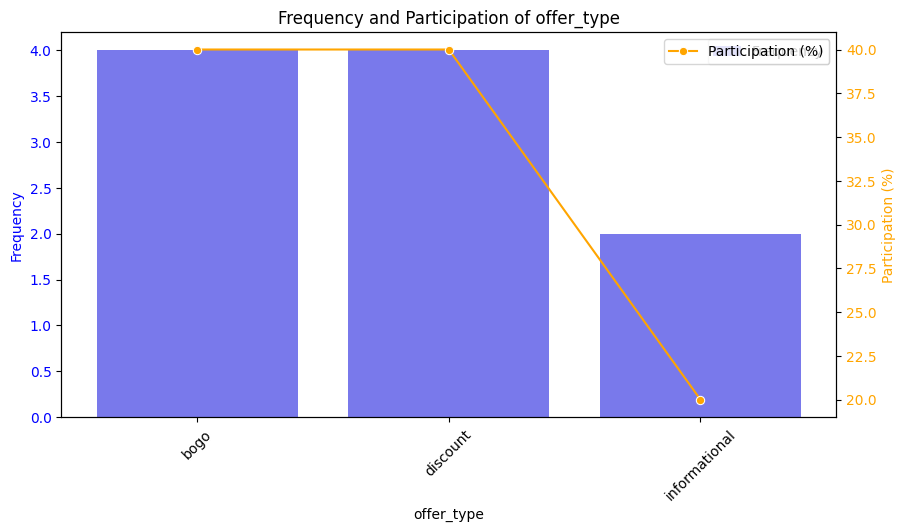

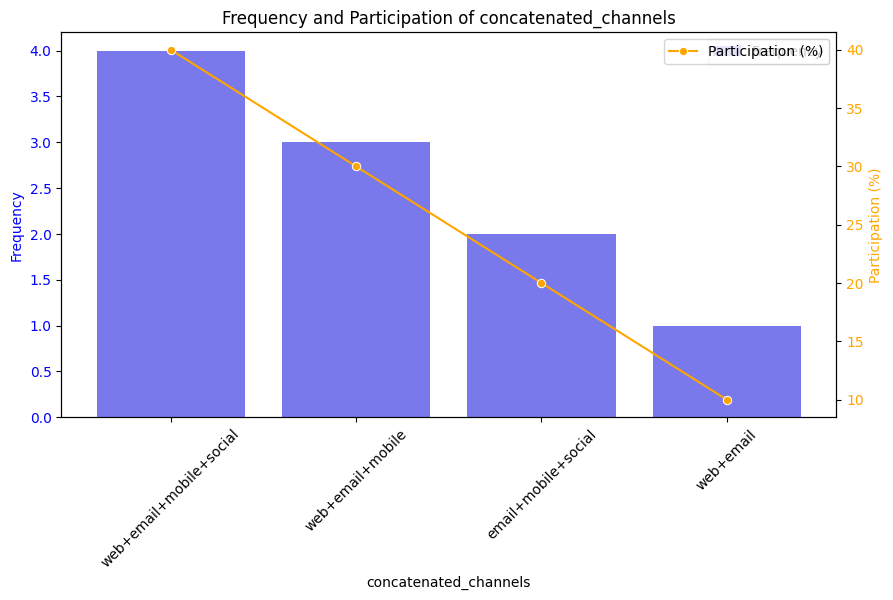

In [14]:
explore_qualitative_variables(new_portfolio, ["offer_type","concatenated_channels"])

#### Quantitative Analysis

       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000


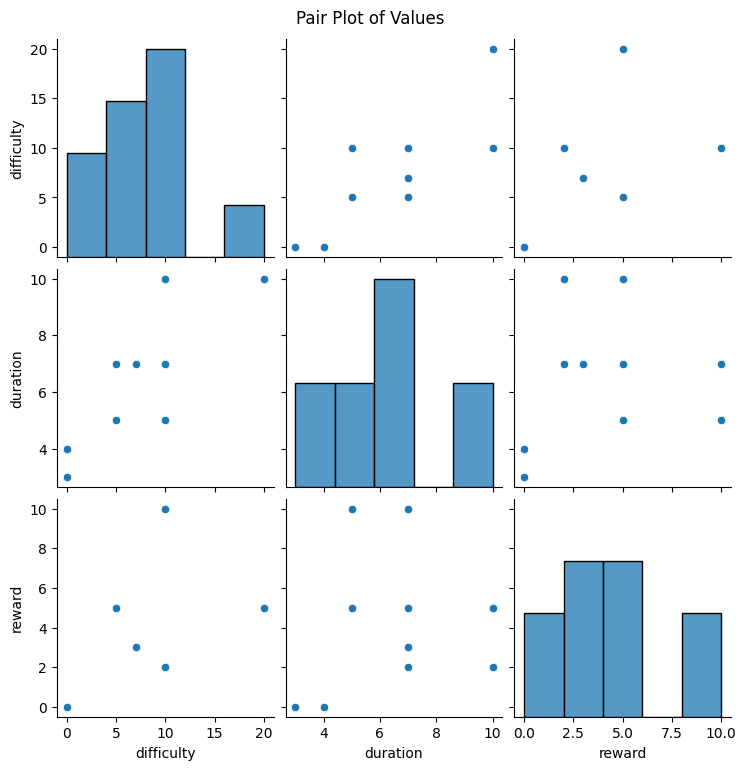

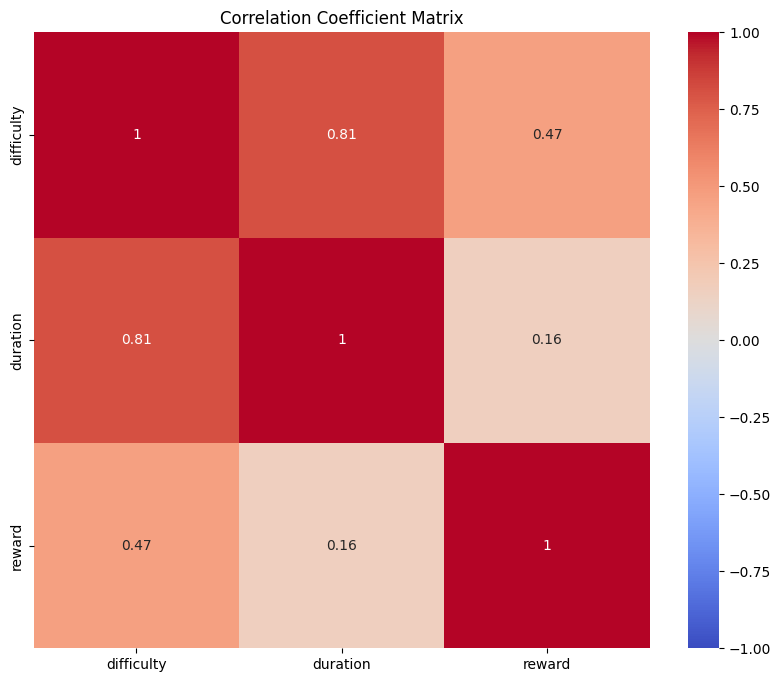

In [15]:
explore_quantitive_variables(portfolio, ["difficulty","duration","reward"])

### Profile

#### Qualitative Analysis

In [16]:
grouped_size = profile.groupby('gender').size().reset_index(name='Count')
print(grouped_size)

  gender  Count
0      F   6129
1      M   8484
2      O    212


In [17]:
new_profile = profile
new_profile["gender"] = new_profile["gender"].replace(0,"NA")

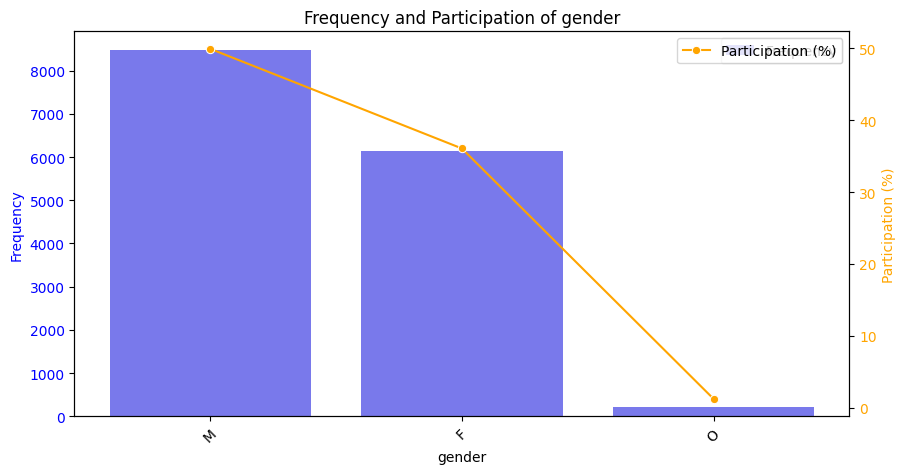

In [18]:
explore_qualitative_variables(new_profile, ["gender"])

#### Quantitative Analysis

                age         income
count  17000.000000   17000.000000
mean      62.531412   57037.000000
std       26.738580   29734.044501
min       18.000000       0.000000
25%       45.000000   40000.000000
50%       58.000000   59000.000000
75%       73.000000   76000.000000
max      118.000000  120000.000000


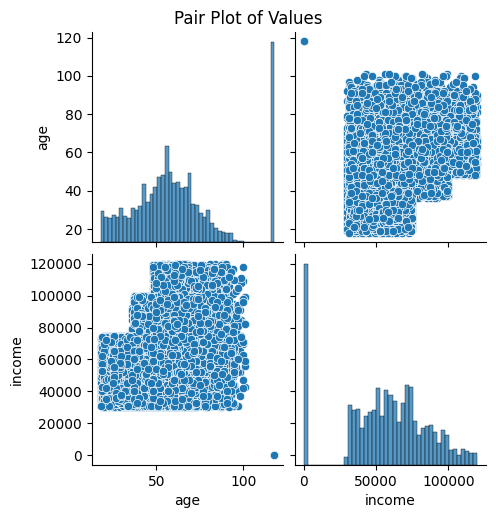

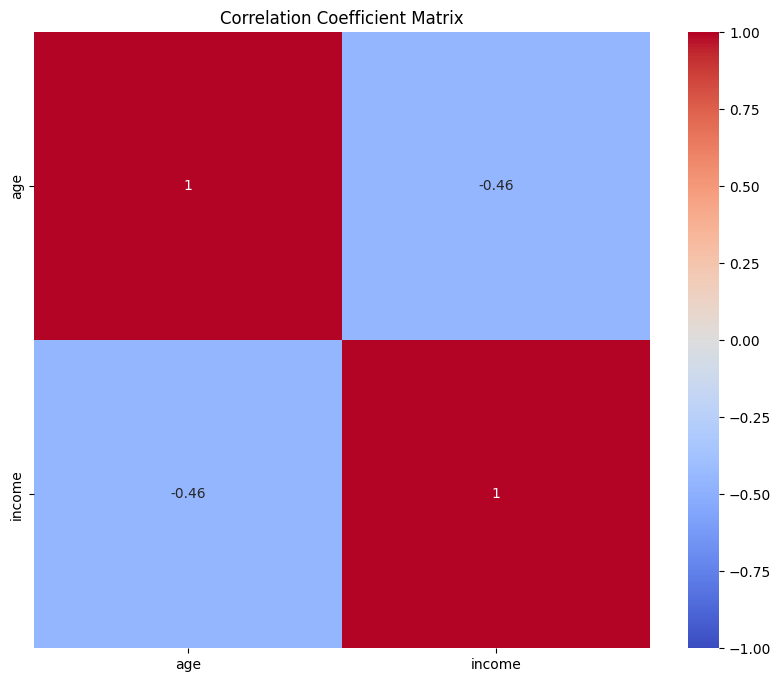

In [19]:
explore_quantitive_variables(profile.fillna(0), ["age","income"])

### Transcript

#### Qualitative Analysis

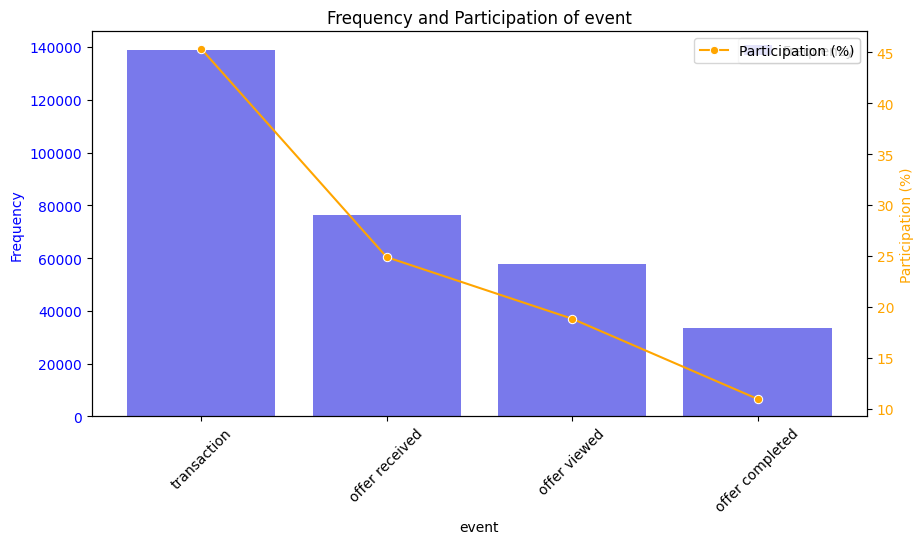

In [20]:
explore_qualitative_variables(transcript, ["event"])

#### Quantitative Analysis

In [21]:
transcript.fillna(0).describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [22]:
result_df = transcript.groupby(["event","person"])['value'].count().reset_index()
result_df.head()

,event,person,value
0,offer completed,0009655768c64bdeb2e877511632db8f,3
1,offer completed,0011e0d4e6b944f998e987f904e8c1e5,3
2,offer completed,0020c2b971eb4e9188eac86d93036a77,3
3,offer completed,0020ccbbb6d84e358d3414a3ff76cffd,3
4,offer completed,003d66b6608740288d6cc97a6903f4f0,3


In [23]:
pivoted_df = pd.pivot_table(result_df, values='value', index='person', columns='event', aggfunc='sum', fill_value=0)
pivoted_df = pivoted_df.reset_index()
pivoted_df.head()

event,person,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12


event  offer completed  offer received  offer viewed   transaction
count     17000.000000    17000.000000  17000.000000  17000.000000
mean          1.975235        4.486882      3.395588      8.173706
std           1.605563        1.076165      1.297653      5.116250
min           0.000000        0.000000      0.000000      0.000000
25%           1.000000        4.000000      2.750000      4.000000
50%           2.000000        5.000000      3.000000      7.000000
75%           3.000000        5.000000      4.000000     11.000000
max           6.000000        6.000000      6.000000     36.000000


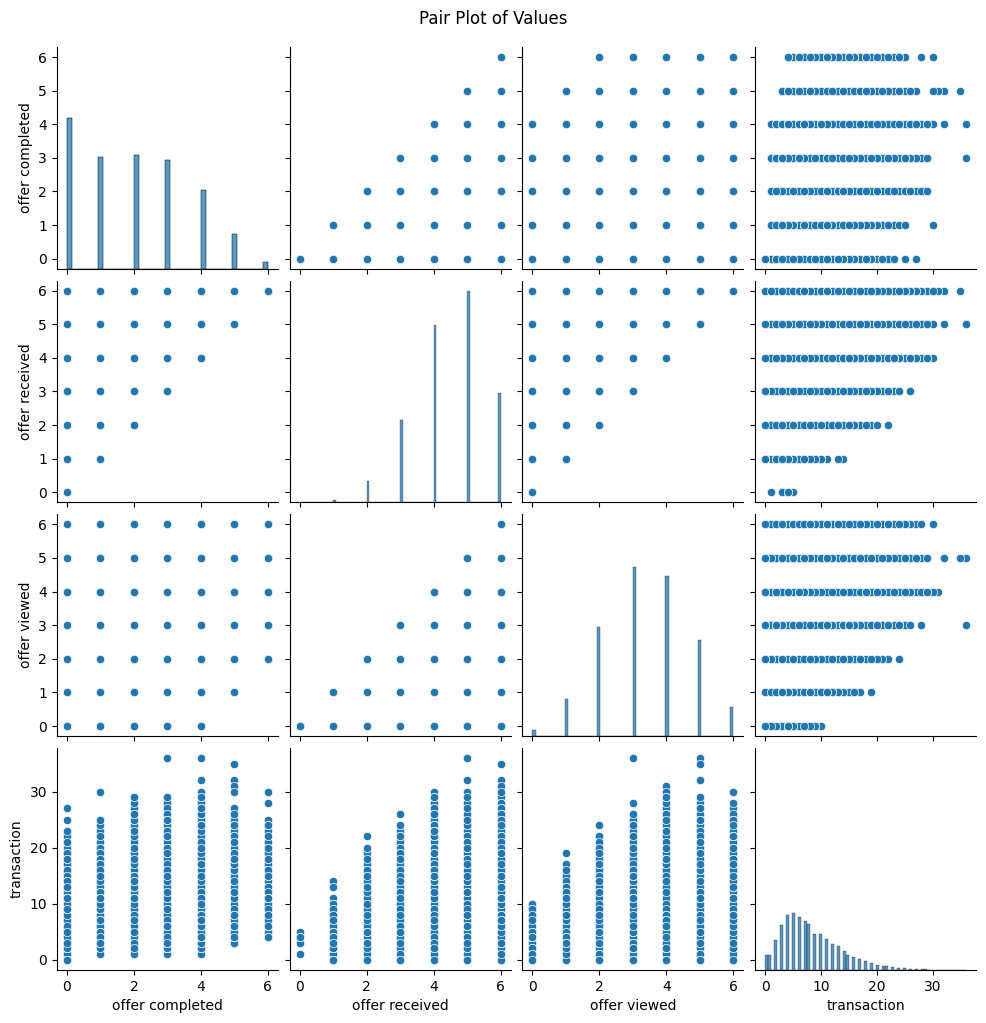

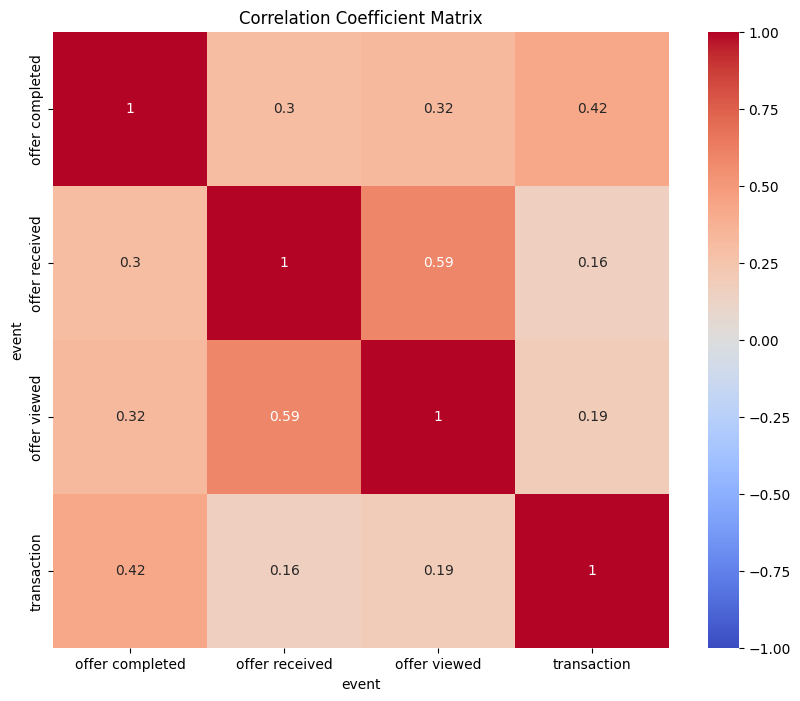

In [24]:
explore_quantitive_variables(pivoted_df, ["offer completed","offer received","offer viewed","transaction"])

## Preprocessing

### Portfolio

In [25]:
cleaned_portfolio_df = convert_list_to_string(portfolio, "channels").reset_index()
cleaned_portfolio_df["offer_group"] = 'offer_group_ ' + cleaned_portfolio_df['index'].astype(str)
cleaned_portfolio_df = cleaned_portfolio_df.drop(columns=["index"])
cleaned_portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id,concatenated_channels,offer_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,email+mobile+social,offer_group_ 0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,web+email+mobile,offer_group_ 2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,web+email+mobile,offer_group_ 3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,web+email,offer_group_ 4


### Profile

In [26]:
cleaned_profile = profile.fillna(0)
cleaned_profile["gender"] = cleaned_profile["gender"].replace(0,"NA")
cleaned_profile["became_member_on"] = pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d', errors='coerce')
cleaned_profile.head(9)

,gender,age,id,became_member_on,income
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NA,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,NA,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,0.0
7,NA,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,0.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0


### Transcript

In [27]:
cleaned_transcript_df = transcript
cleaned_transcript_df["offer_id"] = cleaned_transcript_df["value"].apply(lambda x: x.get("offer id"))
cleaned_transcript_df["amount"] = cleaned_transcript_df["value"].apply(lambda x: x.get("amount"))
cleaned_transcript_df.head()

,person,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [28]:
cleaned_transcript_df[~cleaned_transcript_df['amount'].isna()].head()

,person,event,value,time,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,None,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,None,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,None,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,None,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,None,18.97


## Feature Engineering

### Portfolio

In [29]:
## Does the columns offert_type + channels generates unique ids?
result = check_unique_combinations(cleaned_portfolio_df, ["concatenated_channels","offer_type"])
print("Are the combinations unique?", result)

Are the combinations unique? False


In [30]:
# What about finding a single field that represents the numeric values like an score?
score_portfolio_df = score_portfolio(cleaned_portfolio_df)
score_portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id,concatenated_channels,offer_group,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,score
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,email+mobile+social,offer_group_ 0,1.0,0.50,0.7,74.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1,1.0,0.50,0.5,70.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,web+email+mobile,offer_group_ 2,0.0,0.00,0.4,8.0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,web+email+mobile,offer_group_ 3,0.5,1.00,0.7,74.0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,web+email,offer_group_ 4,0.5,0.25,1.0,50.0


In [31]:
## Does the columns offert_type + channels generates + score generate unique ids?
fields = ["concatenated_channels","offer_type","score"]
result = check_unique_combinations(score_portfolio_df, fields)
print("Are the combinations unique?", result)

Are the combinations unique? False


In [32]:
# Which Id is duped?
duplicated_df = find_duplicate_ids(score_portfolio_df, fields)
duplicated_df.head()

,reward,channels,difficulty,duration,offer_type,id,concatenated_channels,offer_group,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,score
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1,1.0,0.5,0.5,70.0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,web+email+mobile+social,offer_group_ 8,0.5,1.0,0.5,70.0


Text(0.5, 1.0, 'Bar Plot of Score by Channels and Offer Type')

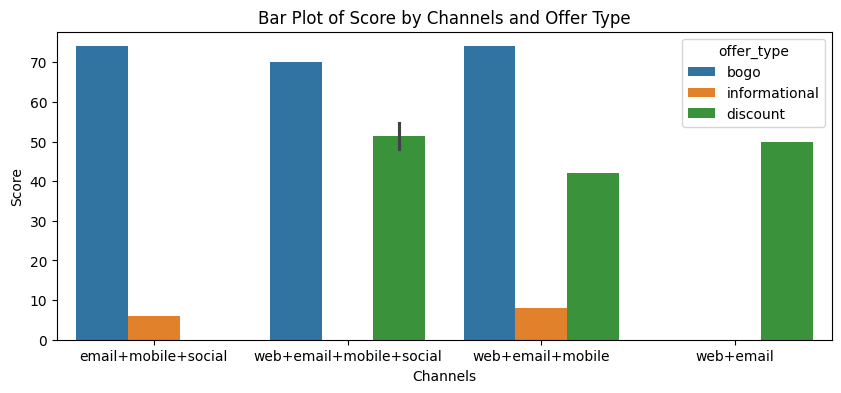

In [33]:
# Create the bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='concatenated_channels', y='score', hue='offer_type', data=score_portfolio_df)

# Add labels and title
plt.xlabel('Channels')
plt.ylabel('Score')
plt.title('Bar Plot of Score by Channels and Offer Type')

In [34]:
scale_score_portfolio_df = max_scaling(score_portfolio_df,"score")
scale_score_portfolio_df[["max_scaling_reward","min_scaling_difficulty","max_scaling_duration","max_scaling_score"]].head()

,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,max_scaling_score
0,1.0,0.50,0.7,1.000000
1,1.0,0.50,0.5,0.945946
2,0.0,0.00,0.4,0.108108
3,0.5,1.00,0.7,1.000000
4,0.5,0.25,1.0,0.675676


In [35]:
scale_score_portfolio_df[["max_scaling_reward","min_scaling_difficulty","max_scaling_duration","max_scaling_score"]].describe()

,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,max_scaling_score
count,10.000000,10.000000,10.00000,10.000000
mean,0.420000,0.496429,0.65000,0.671042
std,0.358391,0.350918,0.23214,0.341266
min,0.000000,0.000000,0.30000,0.081081
25%,0.200000,0.312500,0.50000,0.587838
50%,0.400000,0.500000,0.70000,0.706564
75%,0.500000,0.660714,0.70000,0.945946
max,1.000000,1.000000,1.00000,1.000000


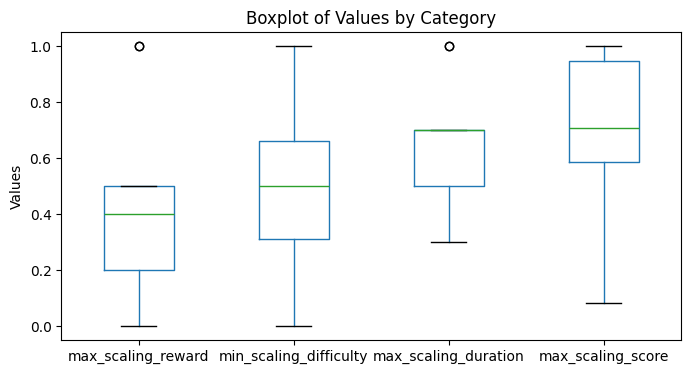

In [36]:
# Create a box plot
plt.figure(figsize=(8, 4))
score_portfolio_df.boxplot(column=["max_scaling_reward","min_scaling_difficulty","max_scaling_duration","max_scaling_score"], grid=False)

plt.title('Boxplot of Values by Category')
plt.suptitle('')  # Suppress the default title
plt.ylabel('Values')
plt.show()

In [37]:
final_portfolio_df = score_portfolio_df
final_portfolio_df = final_portfolio_df.rename(columns={'id': 'portfolio_id'})
final_portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,portfolio_id,concatenated_channels,offer_group,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,score,max_scaling_score
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,email+mobile+social,offer_group_ 0,1.0,0.50,0.7,74.0,1.000000
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1,1.0,0.50,0.5,70.0,0.945946
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,web+email+mobile,offer_group_ 2,0.0,0.00,0.4,8.0,0.108108
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,web+email+mobile,offer_group_ 3,0.5,1.00,0.7,74.0,1.000000
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,web+email,offer_group_ 4,0.5,0.25,1.0,50.0,0.675676


### Profile

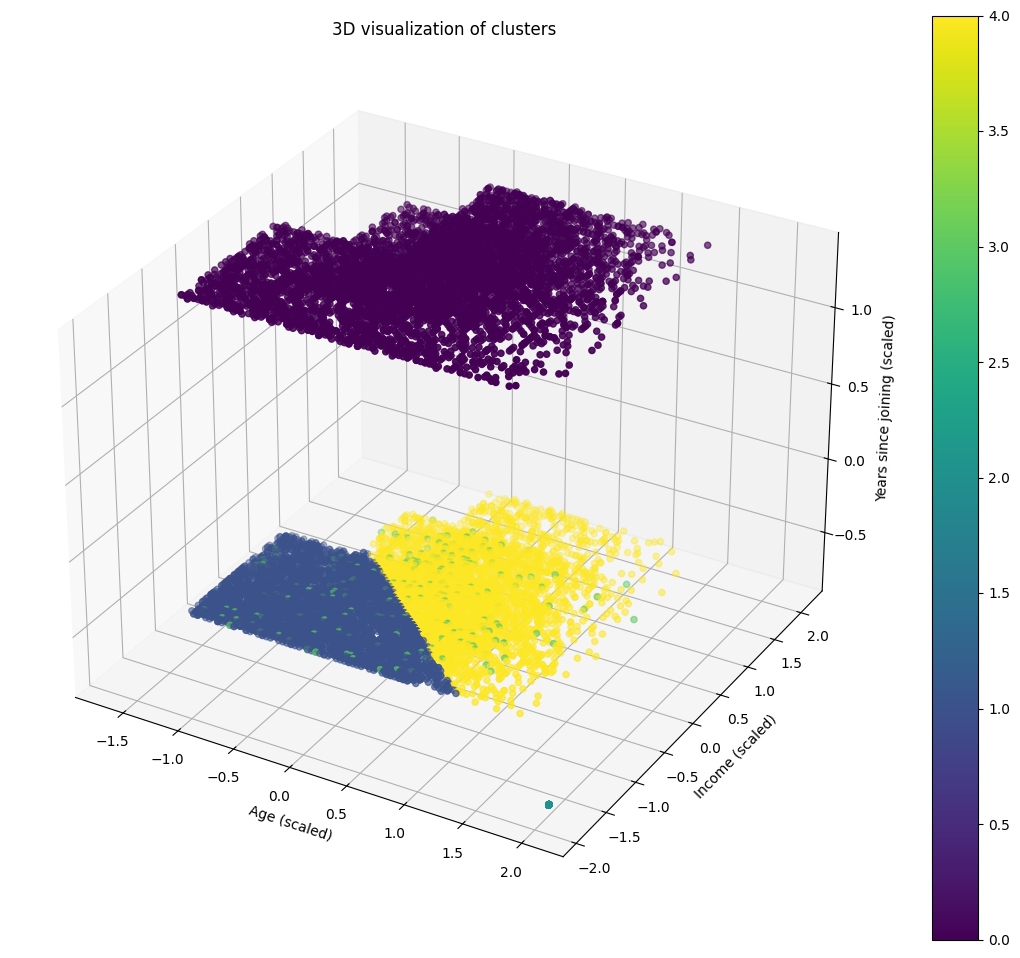

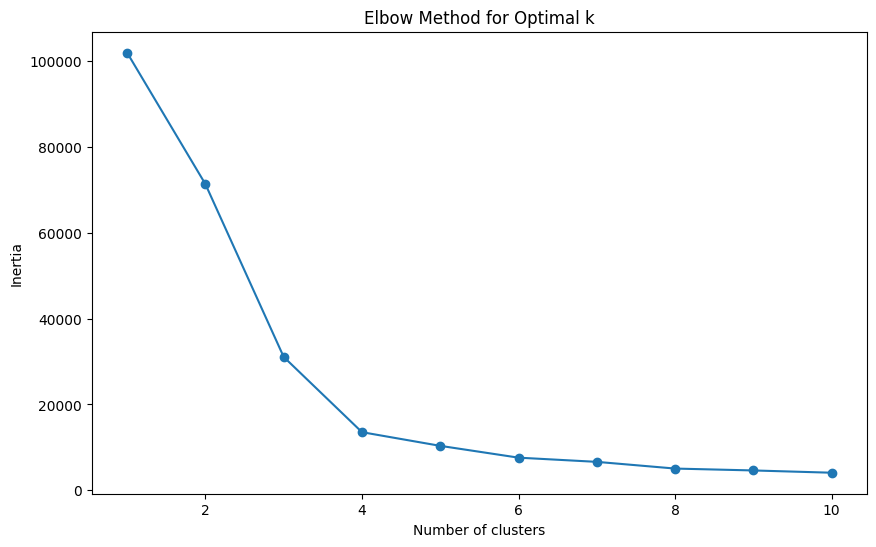

,gender,age,id,became_member_on,income,customer_type
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0
4,NA,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,2


In [38]:
clasify_profile_df = generate_profile_kmeans_clusters(cleaned_profile,5)
clasify_profile_df.head()

In [39]:
final_profile_df = clasify_profile_df
final_profile_df['years_since_joining'] = (pd.Timestamp('11/28/2024') - pd.to_datetime(final_profile_df['became_member_on'])).dt.days/365.25
final_profile_df = final_profile_df.rename(columns={'id': 'profile_id'})
final_profile_df.head()

,gender,age,profile_id,became_member_on,income,customer_type,years_since_joining
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,2,7.791923
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,7.373032
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,2,6.381930
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,7.556468
4,NA,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,2,7.318275


In [40]:
profile_result_df = final_profile_df.groupby(['customer_type', 'gender']).agg(
    age_min=('age', 'min'),
    age_max=('age', 'max'),
    income_min=('income', 'min'),
    income_max=('income', 'max'),
    years_min=('years_since_joining', 'min'),
    years_max=('years_since_joining', 'max'),
).reset_index()

profile_result_df.head(5)

,customer_type,gender,age_min,age_max,income_min,income_max,years_min,years_max
0,0,F,18,101,30000.0,120000.0,6.343600,11.331964
1,1,M,18,82,30000.0,77000.0,6.343600,11.331964
2,2,NA,118,118,0.0,0.0,6.343600,11.323751
3,3,O,20,100,30000.0,100000.0,6.365503,11.192334
4,4,M,36,100,30000.0,120000.0,6.343600,11.334702


### Transcript

In [41]:
transcript_renamed_df = cleaned_transcript_df.rename(columns={'offer_id': 'portfolio_id','person':'profile_id'})
final_transcript_df = pd.merge(transcript_renamed_df ,final_portfolio_df, on="portfolio_id", how="left")
final_transcript_df = pd.merge(final_transcript_df,final_profile_df, on="profile_id", how="inner")
final_transcript_df.head()

,profile_id,event,value,time,portfolio_id,amount,reward,channels,difficulty,duration,...,min_scaling_difficulty,max_scaling_duration,score,max_scaling_score,gender,age,became_member_on,income,customer_type,years_since_joining
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,...,1.0,0.7,74.0,1.0,F,75,2017-05-09,100000.0,0,7.556468
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,...,1.0,0.7,74.0,1.0,F,75,2017-05-09,100000.0,0,7.556468
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,None,19.89,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,0,7.556468
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,None,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,0,7.556468
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,None,17.78,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,0,7.556468


### Features

In [42]:
features_df = final_transcript_df[["profile_id","customer_type","event","offer_group","time","amount","score"]].fillna(0)
features_df["label"] = np.where(features_df['offer_group'] == 0, features_df['event'] , features_df['offer_group'].astype(str))
features_df["label"] = np.where(features_df['label'] == 'transaction', 'amount' , features_df['label'])
features_df["value"] = np.where(features_df['event'] == 'transaction', features_df['amount'] , features_df['score'])
features_df["count"] = 1
features_df.head()

,profile_id,customer_type,event,offer_group,time,amount,score,label,value,count
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer received,offer_group_ 3,0,0.00,74.0,offer_group_ 3,74.00,1
1,78afa995795e4d85b5d9ceeca43f5fef,0,offer viewed,offer_group_ 3,6,0.00,74.0,offer_group_ 3,74.00,1
2,78afa995795e4d85b5d9ceeca43f5fef,0,transaction,0,132,19.89,0.0,amount,19.89,1
3,78afa995795e4d85b5d9ceeca43f5fef,0,offer completed,0,132,0.00,0.0,offer completed,0.00,1
4,78afa995795e4d85b5d9ceeca43f5fef,0,transaction,0,144,17.78,0.0,amount,17.78,1


In [43]:
pivoted_offer_group_df = (
    pd.pivot_table(
        features_df[features_df["event"]!="offer completed"], 
        values='value', 
        index=['profile_id','customer_type'], 
        columns='label', 
        aggfunc='sum', 
        fill_value=0
    ).reset_index()
)
pivoted_offer_group_df.head()

label,profile_id,customer_type,amount,offer_group_ 0,offer_group_ 1,offer_group_ 2,offer_group_ 3,offer_group_ 4,offer_group_ 5,offer_group_ 6,offer_group_ 7,offer_group_ 8,offer_group_ 9
0,0009655768c64bdeb2e877511632db8f,1,127.60,0.0,0.0,16.0,0.0,0.0,0.000000,96.0,12.0,140.0,42.0
1,00116118485d4dfda04fdbaba9a87b5c,2,4.09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,280.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,79.46,0.0,0.0,16.0,148.0,100.0,109.142857,0.0,12.0,0.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,0,196.86,74.0,140.0,0.0,0.0,0.0,0.000000,144.0,12.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0,154.05,0.0,0.0,0.0,148.0,0.0,109.142857,0.0,12.0,140.0,0.0


In [44]:
events_df = (
    pd.pivot_table(
        features_df, 
        values='count', 
        index=['profile_id'], 
        columns='event', 
        aggfunc='sum', 
        fill_value=0
    ).reset_index()
)
events_df.head()

event,profile_id,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12


In [45]:
sum_time_df = features_df[features_df["event"]=="transaction"].groupby("profile_id")["time"].sum().reset_index()
sum_time_df.head()

,profile_id,time
0,0009655768c64bdeb2e877511632db8f,4344
1,00116118485d4dfda04fdbaba9a87b5c,1224
2,0011e0d4e6b944f998e987f904e8c1e5,2256
3,0020c2b971eb4e9188eac86d93036a77,2790
4,0020ccbbb6d84e358d3414a3ff76cffd,4500


In [46]:
final_features_df = pd.merge(pivoted_offer_group_df,events_df,on="profile_id",how="left")
final_features_df = pd.merge(final_features_df,sum_time_df,on="profile_id",how="left").fillna(0)
final_features_df.head()

,profile_id,customer_type,amount,offer_group_ 0,offer_group_ 1,offer_group_ 2,offer_group_ 3,offer_group_ 4,offer_group_ 5,offer_group_ 6,offer_group_ 7,offer_group_ 8,offer_group_ 9,offer completed,offer received,offer viewed,transaction,time
0,0009655768c64bdeb2e877511632db8f,1,127.60,0.0,0.0,16.0,0.0,0.0,0.000000,96.0,12.0,140.0,42.0,3,5,4,8,4344.0
1,00116118485d4dfda04fdbaba9a87b5c,2,4.09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,280.0,0.0,0,2,2,3,1224.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,79.46,0.0,0.0,16.0,148.0,100.0,109.142857,0.0,12.0,0.0,0.0,3,5,5,5,2256.0
3,0020c2b971eb4e9188eac86d93036a77,0,196.86,74.0,140.0,0.0,0.0,0.0,0.000000,144.0,12.0,0.0,0.0,3,5,3,8,2790.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0,154.05,0.0,0.0,0.0,148.0,0.0,109.142857,0.0,12.0,140.0,0.0,3,4,4,12,4500.0


In [47]:
columns = list(set(final_features_df.columns.tolist()) - set(["profile_id","customer_type"]))
print(columns)

['amount', 'offer_group_ 1', 'offer_group_ 6', 'offer_group_ 7', 'transaction', 'offer_group_ 3', 'offer_group_ 9', 'offer_group_ 4', 'time', 'offer_group_ 2', 'offer completed', 'offer viewed', 'offer_group_ 5', 'offer_group_ 0', 'offer received', 'offer_group_ 8']


             amount  offer_group_ 1  offer_group_ 6  offer_group_ 7  \
count  17000.000000    17000.000000    17000.000000    17000.000000   
mean     104.438351       61.315882       42.138353        5.048824   
std      125.922619       88.428064       60.662225        7.392612   
min        0.000000        0.000000        0.000000        0.000000   
25%       21.820000        0.000000        0.000000        0.000000   
50%       69.405000        0.000000        0.000000        0.000000   
75%      148.782500      140.000000       96.000000       12.000000   
max     1608.690000      560.000000      480.000000       60.000000   

        transaction  offer_group_ 3  offer_group_ 9  offer_group_ 4  \
count  17000.000000    17000.000000    17000.000000    17000.000000   
mean       8.173706       51.573647       29.029412       30.385294   
std        5.116250       78.572465       44.578932       46.437265   
min        0.000000        0.000000        0.000000        0.000000   
25%  

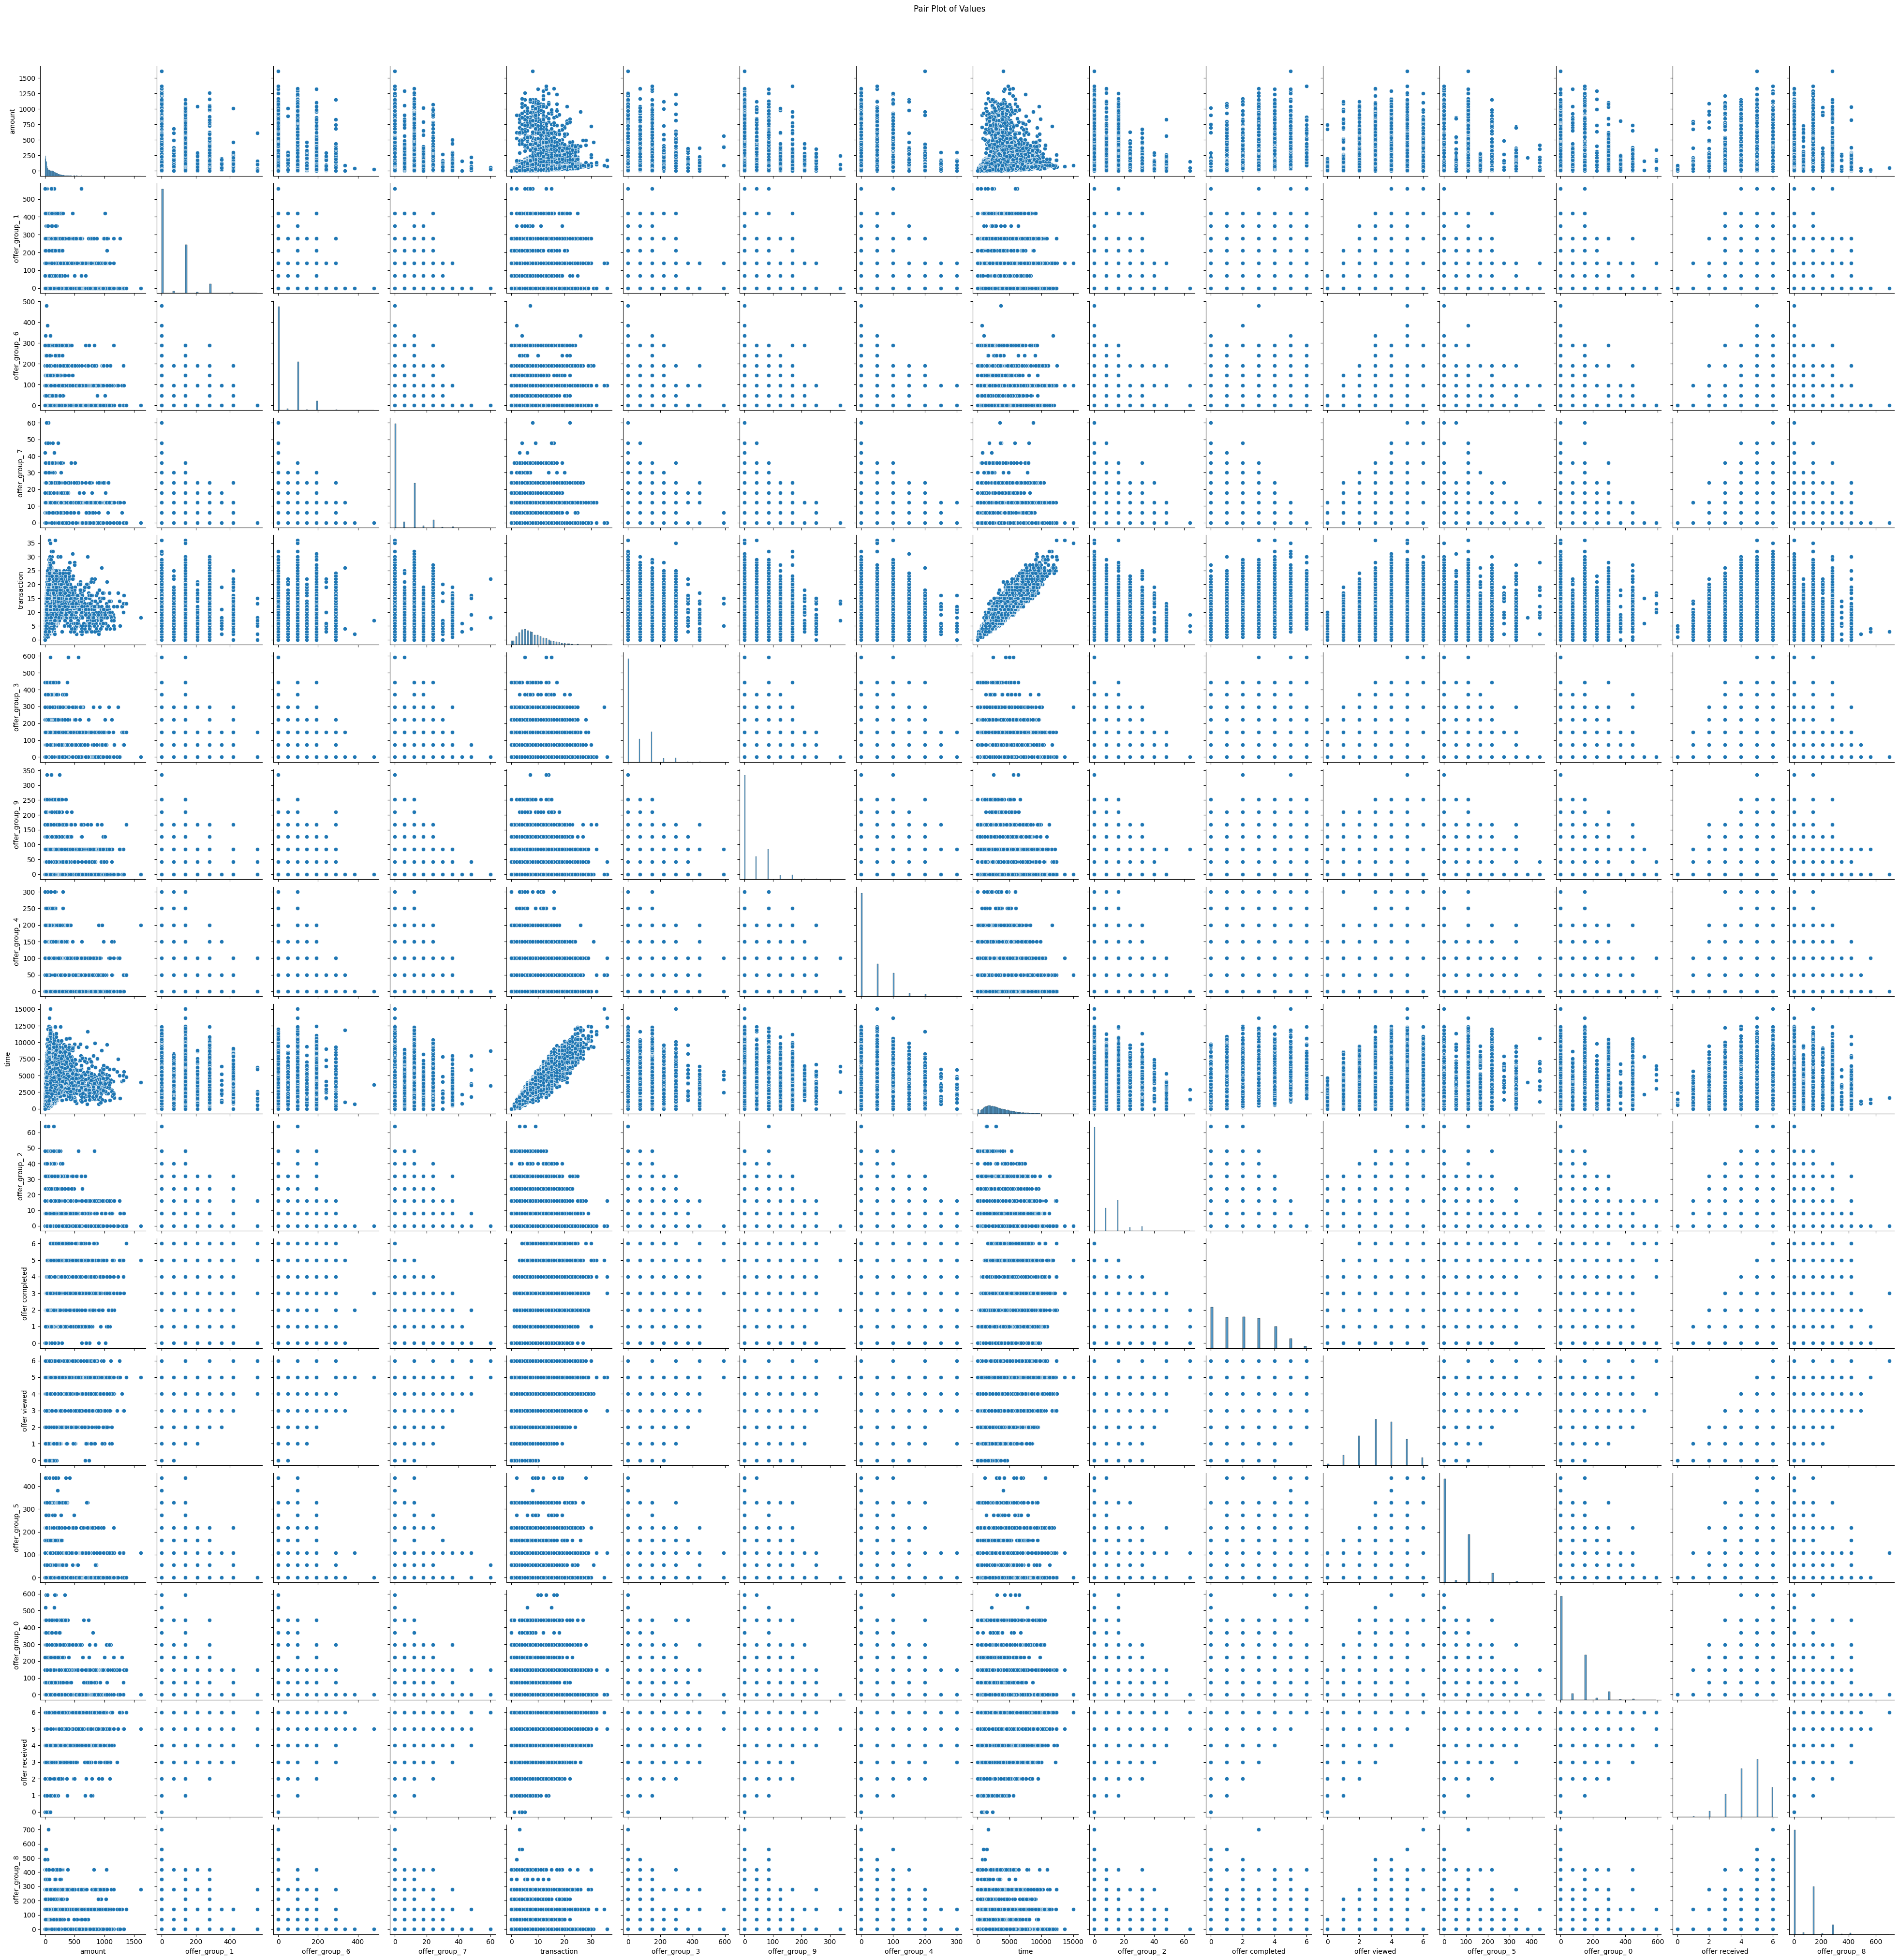

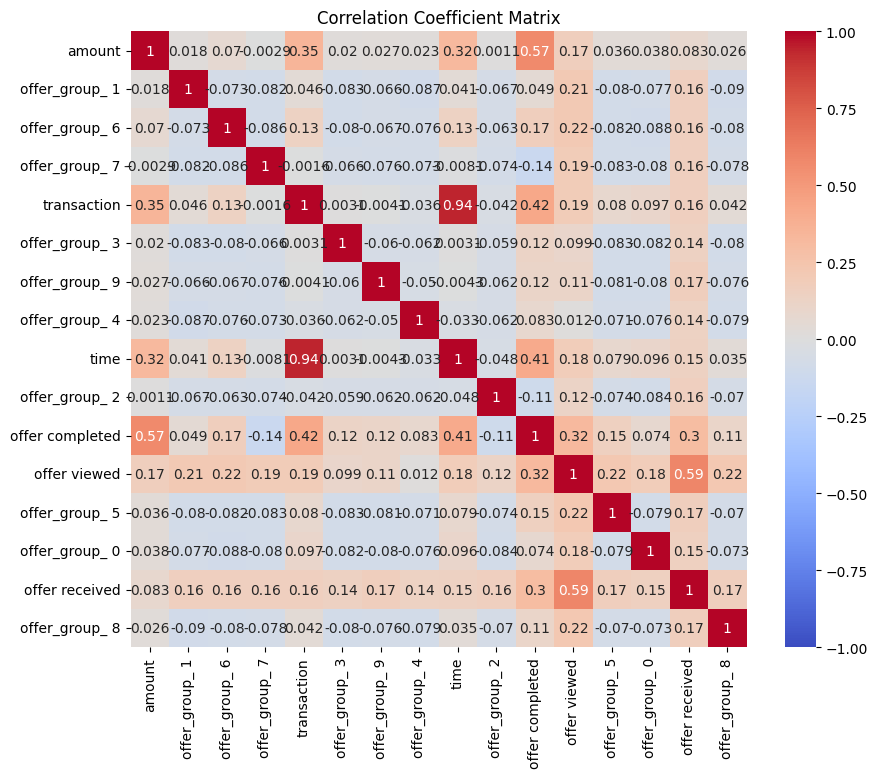

In [48]:
explore_quantitive_variables(final_features_df, columns)

## Inference

In [49]:
model_df= final_features_df
model_df["customer_type"] = "customer_type_" + model_df["customer_type"].astype("str")
model_df.head()

,profile_id,customer_type,amount,offer_group_ 0,offer_group_ 1,offer_group_ 2,offer_group_ 3,offer_group_ 4,offer_group_ 5,offer_group_ 6,offer_group_ 7,offer_group_ 8,offer_group_ 9,offer completed,offer received,offer viewed,transaction,time
0,0009655768c64bdeb2e877511632db8f,customer_type_1,127.60,0.0,0.0,16.0,0.0,0.0,0.000000,96.0,12.0,140.0,42.0,3,5,4,8,4344.0
1,00116118485d4dfda04fdbaba9a87b5c,customer_type_2,4.09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,280.0,0.0,0,2,2,3,1224.0
2,0011e0d4e6b944f998e987f904e8c1e5,customer_type_3,79.46,0.0,0.0,16.0,148.0,100.0,109.142857,0.0,12.0,0.0,0.0,3,5,5,5,2256.0
3,0020c2b971eb4e9188eac86d93036a77,customer_type_0,196.86,74.0,140.0,0.0,0.0,0.0,0.000000,144.0,12.0,0.0,0.0,3,5,3,8,2790.0
4,0020ccbbb6d84e358d3414a3ff76cffd,customer_type_0,154.05,0.0,0.0,0.0,148.0,0.0,109.142857,0.0,12.0,140.0,0.0,3,4,4,12,4500.0


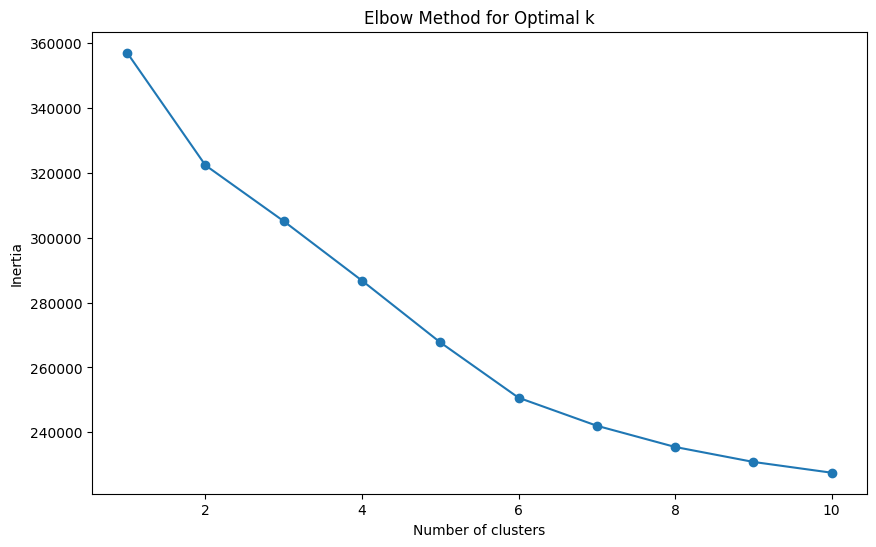

In [50]:
inference_df = generate_model_kmeans_clusters(model_df, 6)

## Analysis

In [51]:
aggregation_fields = list(set(inference_df.drop(columns=["profile_id"])) - set(["cluster","customer_type"]))
cluster_df = inference_df.groupby(["cluster","customer_type"])[aggregation_fields].sum().reset_index()
cluster_df["cluster"] = "cluster_" + cluster_df["cluster"].astype("str")
print(f"Number of rows: {len(cluster_df)}")
cluster_df.head(9)

Number of rows: 9


,cluster,customer_type,amount,offer_group_ 1,offer_group_ 6,offer_group_ 7,transaction,offer_group_ 3,offer_group_ 9,offer_group_ 4,time,offer_group_ 2,offer completed,offer viewed,offer_group_ 5,offer_group_ 0,offer received,offer_group_ 8
0,cluster_0,customer_type_0,390142.99,113960.0,94704.0,7194.0,21153,94646.0,50778.0,45800.0,8073870.0,7264.0,6067,6583,104067.714286,133348.0,7893,115850.0
1,cluster_0,customer_type_1,149800.98,68460.0,62976.0,4032.0,15353,51578.0,29316.0,23050.0,5910174.0,3832.0,3177,3867,63357.428571,82658.0,4671,67410.0
2,cluster_0,customer_type_2,1513.49,1120.0,2592.0,48.0,462,814.0,882.0,600.0,176244.0,120.0,66,108,1582.571429,2072.0,129,3010.0
3,cluster_0,customer_type_4,149241.87,35350.0,35040.0,2028.0,7185,25308.0,17472.0,13700.0,2745840.0,2096.0,1872,2113,31051.142857,42846.0,2466,39480.0
4,cluster_1,customer_type_2,38996.08,136710.0,86928.0,10686.0,14534,122322.0,68796.0,68900.0,5583942.0,12816.0,1069,7757,104777.142857,130388.0,9647,133420.0
5,cluster_2,customer_type_1,175827.53,210700.0,131376.0,19260.0,27792,160950.0,88242.0,102000.0,10554654.0,18968.0,4081,10534,154273.428571,208828.0,15637,201460.0
6,cluster_3,customer_type_4,370020.48,204820.0,134400.0,17532.0,22464,183668.0,103572.0,111500.0,8576790.0,20816.0,7336,11787,161695.142857,205424.0,15355,208250.0
7,cluster_4,customer_type_0,473552.01,261240.0,159888.0,23910.0,28229,224368.0,128016.0,143350.0,10733760.0,26848.0,9410,14203,186907.142857,245088.0,19563,257460.0
8,cluster_5,customer_type_3,26356.54,10010.0,8448.0,1140.0,1781,13098.0,6426.0,7650.0,667014.0,1328.0,501,773,9932.000000,13024.0,916,12110.0


In [52]:
quintile_analysis_df = replace_with_quintile_labels(cluster_df)
quintile_analysis_df.head()

,cluster,customer_type,amount,offer_group_ 1,offer_group_ 6,offer_group_ 7,transaction,offer_group_ 3,offer_group_ 9,offer_group_ 4,time,offer_group_ 2,offer completed,offer viewed,offer_group_ 5,offer_group_ 0,offer received,offer_group_ 8
0,cluster_0,customer_type_0,A,C,B,C,B,C,C,C,B,C,B,C,C,B,C,C
1,cluster_0,customer_type_1,C,D,D,D,C,D,D,D,C,D,C,D,D,D,D,D
2,cluster_0,customer_type_2,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E
3,cluster_0,customer_type_4,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D
4,cluster_1,customer_type_2,D,B,C,B,D,B,B,B,D,B,D,B,B,C,B,B


In [53]:
offers_ranking_df = final_portfolio_df[["offer_group","score"]].sort_values(by="score",ascending=False)
offers_ranking_df["rank"] = range(1, len(offers_ranking_df) + 1)
offers_ranking_df.head(10)

,offer_group,score,rank
0,offer_group_ 0,74.000000,1
3,offer_group_ 3,74.000000,2
1,offer_group_ 1,70.000000,3
8,offer_group_ 8,70.000000,4
5,offer_group_ 5,54.571429,5
4,offer_group_ 4,50.000000,6
6,offer_group_ 6,48.000000,7
9,offer_group_ 9,42.000000,8
2,offer_group_ 2,8.000000,9
7,offer_group_ 7,6.000000,10


In [54]:
offers_list = offers_ranking_df['offer_group'].tolist()
print(offers_list)

['offer_group_ 0', 'offer_group_ 3', 'offer_group_ 1', 'offer_group_ 8', 'offer_group_ 5', 'offer_group_ 4', 'offer_group_ 6', 'offer_group_ 9', 'offer_group_ 2', 'offer_group_ 7']


In [55]:
variables = ["amount","time","transaction","offer received","offer received","offer completed"] + offers_list
sorted_list = ["cluster","customer_type"] + variables
final_df = quintile_analysis_df[sorted_list].copy()
final_df.loc[:,"category"] = final_df[variables].astype(str).agg(''.join, axis=1)
final_df.head(9)

,cluster,customer_type,amount,time,transaction,offer received,offer received,offer completed,offer_group_ 0,offer_group_ 3,offer_group_ 1,offer_group_ 8,offer_group_ 5,offer_group_ 4,offer_group_ 6,offer_group_ 9,offer_group_ 2,offer_group_ 7,category
0,cluster_0,customer_type_0,A,B,B,C,C,B,B,C,C,C,C,C,B,C,C,C,ABBCCCCBBCCCCCBCCC
1,cluster_0,customer_type_1,C,C,C,D,D,C,D,D,D,D,D,D,D,D,D,D,CCCDDDDCDDDDDDDDDD
2,cluster_0,customer_type_2,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,EEEEEEEEEEEEEEEEEE
3,cluster_0,customer_type_4,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D,DDDDDDDDDDDDDDDDDD
4,cluster_1,customer_type_2,D,D,D,B,B,D,C,B,B,B,B,B,C,B,B,B,DDDBBBBDCBBBBBCBBB
5,cluster_2,customer_type_1,B,A,A,A,A,B,A,B,A,B,B,B,B,B,B,A,BAAAAAABABABBBBBBA
6,cluster_3,customer_type_4,B,B,B,B,B,A,B,A,B,A,A,A,A,A,A,B,BBBBBBBABABAAAAAAB
7,cluster_4,customer_type_0,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,AAAAAAAAAAAAAAAAAA
8,cluster_5,customer_type_3,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,EEEEEEEEEEEEEEEEEE


In [56]:
final_df[["cluster","customer_type","category"]].sort_values(by="category",ascending=True).head(9)

,cluster,customer_type,category
7,cluster_4,customer_type_0,AAAAAAAAAAAAAAAAAA
0,cluster_0,customer_type_0,ABBCCCCBBCCCCCBCCC
5,cluster_2,customer_type_1,BAAAAAABABABBBBBBA
6,cluster_3,customer_type_4,BBBBBBBABABAAAAAAB
1,cluster_0,customer_type_1,CCCDDDDCDDDDDDDDDD
4,cluster_1,customer_type_2,DDDBBBBDCBBBBBCBBB
3,cluster_0,customer_type_4,DDDDDDDDDDDDDDDDDD
2,cluster_0,customer_type_2,EEEEEEEEEEEEEEEEEE
8,cluster_5,customer_type_3,EEEEEEEEEEEEEEEEEE


In [57]:
melt_final_df = final_df.drop(columns=["category"]).copy()
melt_final_df = (
    pd.melt(
        melt_final_df, 
        id_vars=['cluster', 'customer_type'], 
        value_vars=offers_list, 
        var_name='offer', 
        value_name='category')
)
print(f"Number of rows: {len(portfolio)}")
melt_final_df.head(10)

Number of rows: 10


,cluster,customer_type,offer,category
0,cluster_0,customer_type_0,offer_group_ 0,B
1,cluster_0,customer_type_1,offer_group_ 0,D
2,cluster_0,customer_type_2,offer_group_ 0,E
3,cluster_0,customer_type_4,offer_group_ 0,D
4,cluster_1,customer_type_2,offer_group_ 0,C
5,cluster_2,customer_type_1,offer_group_ 0,A
6,cluster_3,customer_type_4,offer_group_ 0,B
7,cluster_4,customer_type_0,offer_group_ 0,A
8,cluster_5,customer_type_3,offer_group_ 0,E
9,cluster_0,customer_type_0,offer_group_ 3,C


In [58]:
profile_fileds = list(profile_result_df.columns)

required_fields = (
    [
        "offer",
        "concatenated_channels",
        "offer_type",
        "reward",
        "difficulty",
        "duration"
    ] + 
    profile_fileds + 
    ["category"]
)

In [59]:
rename_profile_result_df = profile_result_df.copy()
rename_profile_result_df["customer_type"] = "customer_type_" + rename_profile_result_df["customer_type"].astype("str")

rename_portfolio_result_df = cleaned_portfolio_df.copy()
rename_portfolio_result_df = rename_portfolio_result_df.rename(columns={"offer_group":"offer"})

analysis_df = melt_final_df.copy()
analysis_df = pd.merge(analysis_df,rename_profile_result_df, on="customer_type",how="inner")
analysis_df = pd.merge(analysis_df,rename_portfolio_result_df, on="offer",how="inner")
analysis_df = analysis_df[required_fields]
analysis_df[required_fields].head()

,offer,concatenated_channels,offer_type,reward,difficulty,duration,customer_type,gender,age_min,age_max,income_min,income_max,years_min,years_max,category
0,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_0,F,18,101,30000.0,120000.0,6.343600,11.331964,B
1,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_0,F,18,101,30000.0,120000.0,6.343600,11.331964,A
2,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_1,M,18,82,30000.0,77000.0,6.343600,11.331964,D
3,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_1,M,18,82,30000.0,77000.0,6.343600,11.331964,A
4,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_2,NA,118,118,0.0,0.0,6.343600,11.323751,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,offer_group_ 7,email+mobile+social,informational,0,0,3,customer_type_2,NA,118,118,0.0,0.0,6.343600,11.323751,E
86,offer_group_ 7,email+mobile+social,informational,0,0,3,customer_type_2,NA,118,118,0.0,0.0,6.343600,11.323751,B
87,offer_group_ 7,email+mobile+social,informational,0,0,3,customer_type_4,M,36,100,30000.0,120000.0,6.343600,11.334702,D
88,offer_group_ 7,email+mobile+social,informational,0,0,3,customer_type_4,M,36,100,30000.0,120000.0,6.343600,11.334702,B


## Conclusions

Premise:

"Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type."

In [60]:
# Best Performance
conclusion_df = analysis_df.copy()
conclusion_df = conclusion_df.sort_values(by='category', ascending=False).drop_duplicates(subset=['offer', 'customer_type'], keep='first').drop(columns=["offer","customer_type"])
conclusion_df.head()

,concatenated_channels,offer_type,reward,difficulty,duration,gender,age_min,age_max,income_min,income_max,years_min,years_max,category
43,web+email+mobile+social,discount,3,7,7,M,36,100,30000.0,120000.0,6.3436,11.334702,A
52,web+email,discount,5,20,10,M,36,100,30000.0,120000.0,6.3436,11.334702,A
64,web+email+mobile,discount,2,10,7,F,18,101,30000.0,120000.0,6.3436,11.331964,A
1,email+mobile+social,bogo,10,10,7,F,18,101,30000.0,120000.0,6.3436,11.331964,A
21,web+email+mobile+social,bogo,10,10,5,M,18,82,30000.0,77000.0,6.3436,11.331964,A


In [61]:
# Other genders
conclusion_df = analysis_df.copy()
conclusion_df = conclusion_df[~conclusion_df["gender"].isin(["F","M"])].sort_values(by='category', ascending=False).drop_duplicates(subset=['offer', 'customer_type'], keep='first').drop(columns=["offer","customer_type"])
conclusion_df.head()

,concatenated_channels,offer_type,reward,difficulty,duration,gender,age_min,age_max,income_min,income_max,years_min,years_max,category
86,email+mobile+social,informational,0,0,3,NA,118,118,0.0,0.0,6.3436,11.323751,B
50,web+email,discount,5,20,10,NA,118,118,0.0,0.0,6.3436,11.323751,B
14,web+email+mobile,bogo,5,5,7,NA,118,118,0.0,0.0,6.3436,11.323751,B
77,web+email+mobile,informational,0,0,4,NA,118,118,0.0,0.0,6.3436,11.323751,B
23,web+email+mobile+social,bogo,10,10,5,NA,118,118,0.0,0.0,6.3436,11.323751,B


## Basic collaborative filtering model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class UserDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class CollaborativeFilteringModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super(CollaborativeFilteringModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        # Output layer for offer group predictions
        self.output_layer = nn.Linear(hidden_dims[-1], 10)  # 10 offer groups
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(self.output_layer(x))

def prepare_data(df):
    """
    Prepare the data for training the model
    """
    # Select feature columns
    feature_cols = [
        'customer_type', 'amount', 'offer_completed', 
        'offer_received', 'offer_viewed', 'transaction', 'time'
    ]
    
    # Target columns (offer groups)
    target_cols = [f'offer_group_{i}' for i in range(10)]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[feature_cols])
    y = df[target_cols].values
    
    return X, y, scaler

def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001):
    """
    Train the collaborative filtering model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, targets).item()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}")
    
    return model

def get_recommendations(model, user_features, scaler, top_n=5):
    """
    Get offer group recommendations for a user
    """
    model.eval()
    with torch.no_grad():
        # Scale the features
        scaled_features = scaler.transform(user_features.reshape(1, -1))
        features = torch.FloatTensor(scaled_features)
        
        # Get predictions
        predictions = model(features).numpy()[0]
        
        # Get top N recommendations
        top_indices = np.argsort(predictions)[-top_n:][::-1]
        top_scores = predictions[top_indices]
        
        recommendations = [
            (f"offer_group_{idx}", score) 
            for idx, score in zip(top_indices, top_scores)
        ]
    
    return recommendations

def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')
    
    # Prepare the data
    X, y, scaler = prepare_data(df)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Create data loaders
    train_dataset = UserDataset(X_train, y_train)
    val_dataset = UserDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=32, shuffle=False
    )
    
    # Initialize and train the model
    model = CollaborativeFilteringModel(input_dim=7)  # 7 input features
    trained_model = train_model(model, train_loader, val_loader)
    
    # Example of getting recommendations for a user
    sample_user_features = np.array([
        1,      # customer_type
        100.0,  # amount
        5,      # offer_completed
        10,     # offer_received
        8,      # offer_viewed
        15,     # transaction
        48.0    # time
    ])
    
    recommendations = get_recommendations(
        trained_model, sample_user_features, scaler
    )
    return recommendations

## Matrix Factorization

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MatrixFactorizationDataset(Dataset):
    def __init__(self, user_features, offer_interactions):
        self.user_features = torch.FloatTensor(user_features)
        self.offer_interactions = torch.FloatTensor(offer_interactions)
    
    def __len__(self):
        return len(self.user_features)
    
    def __getitem__(self, idx):
        return self.user_features[idx], self.offer_interactions[idx]

class MatrixFactorizationModel(nn.Module):
    def __init__(self, n_users, n_offers, n_factors=50, user_features_dim=7):
        super(MatrixFactorizationModel, self).__init__()
        
        # User embedding layers
        self.user_features_layer = nn.Sequential(
            nn.Linear(user_features_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_factors)
        )
        
        # Offer embedding layer
        self.offer_embeddings = nn.Parameter(
            torch.randn(n_offers, n_factors) * 0.01
        )
        
        # Bias terms
        self.user_biases = nn.Parameter(torch.zeros(n_users))
        self.offer_biases = nn.Parameter(torch.zeros(n_offers))
        self.global_bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, user_features):
        # Get user embeddings from features
        user_factors = self.user_features_layer(user_features)
        
        # Calculate predictions
        predictions = torch.mm(user_factors, self.offer_embeddings.t())
        
        # Add biases
        predictions += self.offer_biases.unsqueeze(0)
        predictions += self.user_biases.unsqueeze(1)
        predictions += self.global_bias
        
        return torch.sigmoid(predictions)

def prepare_data(df):
    """
    Prepare user features and offer interactions matrix
    """
    # Prepare user features
    feature_cols = [
        'customer_type', 'amount', 'offer_completed', 
        'offer_received', 'offer_viewed', 'transaction', 'time'
    ]
    
    # Scale features
    scaler = StandardScaler()
    user_features = scaler.fit_transform(df[feature_cols])
    
    # Create offer interactions matrix
    offer_cols = [f'offer_group_{i}' for i in range(10)]
    offer_interactions = df[offer_cols].values
    
    return user_features, offer_interactions, scaler

def train_matrix_factorization(model, train_loader, val_loader, epochs=50, learning_rate=0.001):
    """
    Train the matrix factorization model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user_features, interactions in train_loader:
            user_features = user_features.to(device)
            interactions = interactions.to(device)
            
            optimizer.zero_grad()
            predictions = model(user_features)
            loss = criterion(predictions, interactions)
            
            # Add L2 regularization for embeddings
            l2_reg = torch.norm(model.offer_embeddings) + torch.norm(model.user_biases) + torch.norm(model.offer_biases)
            loss += 0.01 * l2_reg
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user_features, interactions in val_loader:
                user_features = user_features.to(device)
                interactions = interactions.to(device)
                predictions = model(user_features)
                val_loss += criterion(predictions, interactions).item()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}")
    
    return model

def get_recommendations_mf(model, user_features, scaler, top_n=5):
    """
    Get offer recommendations using the matrix factorization model
    """
    model.eval()
    with torch.no_grad():
        # Scale user features
        scaled_features = scaler.transform(user_features.reshape(1, -1))
        features = torch.FloatTensor(scaled_features)
        
        # Get predictions
        predictions = model(features).numpy()[0]
        
        # Get top N recommendations
        top_indices = np.argsort(predictions)[-top_n:][::-1]
        top_scores = predictions[top_indices]
        
        recommendations = [
            (f"offer_group_{idx}", score) 
            for idx, score in zip(top_indices, top_scores)
        ]
    
    return recommendations

def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')
    
    # Prepare the data
    user_features, offer_interactions, scaler = prepare_data(df)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        user_features, offer_interactions, test_size=0.2, random_state=42
    )
    
    # Create data loaders
    train_dataset = MatrixFactorizationDataset(X_train, y_train)
    val_dataset = MatrixFactorizationDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize and train the model
    n_users = len(user_features)
    n_offers = 10  # number of offer groups
    model = MatrixFactorizationModel(n_users, n_offers, n_factors=50)
    
    trained_model = train_matrix_factorization(
        model, train_loader, val_loader
    )
    
    # Example of getting recommendations for a user
    sample_user_features = np.array([
        1,      # customer_type
        100.0,  # amount
        5,      # offer_completed
        10,     # offer_received
        8,      # offer_viewed
        15,     # transaction
        48.0    # time
    ])
    
    recommendations = get_recommendations_mf(
        trained_model, sample_user_features, scaler
    )
    return recommendations